<a href="https://colab.research.google.com/github/MariaMengozzi/esameDI/blob/main/Progetto_esame_DI_con_preprocessing_differenziato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Determinare il prezzo di vendita delle auto

**Programmazione di Applicazioni Data Intensive**\
Laurea in Ingegneria e Scienze Informatiche\
DISI - Università di Bologna, Cesena

Maria Mengozzi

Per prima cosa carichiamo le librerie necessarie ad elaborare i dati:


*   *os.path* per elaborare i percorsi dei file
*   *NumPy* per creare e operare su array N dimesionali
*   *pandas* per caricare e manipolare dati tabulari
*   *matplotlib* e *seaborn* per creare grafici, viene inoltre aggiunta il comando per visualizzarli all'interno del notebook.


In [135]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1 - Descrizione del problema, comprensione e analisi esplorativa dei dati


## Descrizione del problema

Carichiamo il dataset da [Kaggle](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv) contenente le informazioni sulle auto usate elencate su [www.cardekho.com](www.cardekho.com). 

L' obiettivo del progetto è quello di predire una variabile continua, ossia il prezzo di vendita di un' auto usata in base alle sue caratteristiche.

In [136]:
file_zip_url = "https://github.com/MariaMengozzi/esameDI/raw/main/UsedCarsDataset.zip"
file_zip_name = "UsedCarsDataset.zip"
file_name = 'Car details v3.csv'

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

In [137]:
with open(file_name) as dataFile:
    data = pd.read_csv(dataFile, sep=",")

## Comprensione dei dati e analisi esplorativa

Analizziamo ora i dati. 

Il dataset contiene:

In [138]:
data.shape

(8128, 13)

In [139]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


Le 13 **feature** presenti nel dataset sono:

* `name` : nome dell'auto
* `year` : anno in cui l'auto è stata comprata la prima volta
*	`km_driven` : numero di chilometri percorsi dall'auto
*	`fuel` : tipo di carburante utilizzato dall'auto
*	`seller_type`	: indica se l'auto è venduta da un privato o un rivenditore
* `transmission` : tipo di trasmissione dell'auto (automatico o manuale)
* `owner` : numero di proprietari precedenti
* `mileage`	: distanza per unità di carburante
* `engine` :  cilindrata dell'auto
* `max_power`	: potenza massima del motore
* `torque`	: coppia motore, ovvero quanta potenza ci vuole perché l'auto raggiunga una certa velocità.
* `seats` : numero di sedili nell'auto

La variabile che tenteremo di predire è:
*	`selling_price` : prezzo di vendita dell'auto




Osserviamo ora la tipologia delle variabili, in modo da capire se è possibile risparmiare spazio in memoria

In [140]:
data.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

In [141]:
data.info(verbose=False, memory_usage="deep");

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Columns: 13 entries, name to seats
dtypes: float64(1), int64(3), object(9)
memory usage: 5.0 MB


Come si può notare, molte delle feature sono rappresentate da oggetti. Osservando però il dataset si nota che è possibile gestire alcuni dati come categorici, nello specifico `seller_type`, `transmission`, `fuel` e `owner`. Verifichiamo ora i valori che possono assumere tali feature.




In [142]:
data['seller_type'].value_counts()

Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: seller_type, dtype: int64

In [143]:
data['transmission'].value_counts()

Manual       7078
Automatic    1050
Name: transmission, dtype: int64

In [144]:
data['fuel'].value_counts()

Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: fuel, dtype: int64

In [145]:
data['owner'].value_counts()

First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64

Ricarichiamo quindi il dataset specificando quali dati gestire come categorici.

In [146]:
categorical = ["seller_type", "transmission", "fuel", 'owner']
with open(file_name) as dataFile:
    data = pd.read_csv(dataFile, sep=",",  dtype={x:"category" for x in categorical})

print(data.info(verbose=False, memory_usage="deep"))
print()
print(data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Columns: 13 entries, name to seats
dtypes: category(4), float64(1), int64(3), object(5)
memory usage: 3.0 MB
None

name               object
year                int64
selling_price       int64
km_driven           int64
fuel             category
seller_type      category
transmission     category
owner            category
mileage            object
engine             object
max_power          object
torque             object
seats             float64
dtype: object


Si può notare come già la dimensione sia diminuita.

## Rilevazione di valori mancanti

Verifichiamo ora se sono presenti valori mancanti

In [147]:
data.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

Procediamo rimuovendo i valori mancanti trovati nelle feature `mileage`, `engine`, `max_power`, `torque` e `seats`

In [148]:
data.dropna(inplace=True)
#verifichiamo che siano stati rimossi
data.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64

In [149]:
data.head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
5,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
6,Maruti Wagon R LXI DUO BSIII,2007,96000,175000,LPG,Individual,Manual,First Owner,17.3 km/kg,1061 CC,57.5 bhp,"7.8@ 4,500(kgm@ rpm)",5.0
7,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,16.1 kmpl,796 CC,37 bhp,59Nm@ 2500rpm,4.0
8,Toyota Etios VXD,2011,350000,90000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.1 bhp,170Nm@ 1800-2400rpm,5.0
9,Ford Figo Diesel Celebration Edition,2013,200000,169000,Diesel,Individual,Manual,First Owner,20.0 kmpl,1399 CC,68.1 bhp,160Nm@ 2000rpm,5.0


## Conversione del tipo di dato

Osservando sempre il dataset ci si accorge che i valori di alcune feature potrebbero essere considerati come numerici se si togliesse l'unità di misura. Le feature in questione sono:
* `mileage`
* `engine`
* `max_power`
* `torque` per quest'ultima sarà necessario isolare il valore del Nm (Newton*Metro) in quanto solo tale valore rappresenta la vera e propria coppia dell'auto

Procediamo quindi rimuovendo l'unità di misura e cambiando il tipo di dato.

In [150]:
data.mileage = data.mileage.str.replace(' kmpl','')
data.mileage = data.mileage.str.replace(' km/kg','')
data.engine = data.engine.str.replace(' CC','')
data.max_power = data.max_power.str.replace(' bhp','')
#per la coppia motore estraiamo il primo valore numerico
data['torque'] = data.torque.str.extract('(\d+[.\d]*)')

In [151]:
data.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4,1248,74,190,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7,1497,78,12.7,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0,1396,90,22.4,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1,1298,88.2,11.5,5.0


In [152]:
#convertiamo ora i dati da oggetto al tipo numerico più opportuno
data['mileage'] = data.mileage.astype(float)
data['engine'] = data.engine.astype(int)
data['max_power'] = data.max_power.astype(float)
data['torque'] = data.torque.astype(float)
# poichè i posti in auto non possono essere valori floating point li convertiamo ad intero
data['seats'] = data.seats.astype(int)

In [153]:
print(data.info(verbose=False, memory_usage="deep"))
print()
print(data.dtypes)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7906 entries, 0 to 8127
Columns: 13 entries, name to seats
dtypes: category(4), float64(3), int64(5), object(1)
memory usage: 1.2 MB
None

name               object
year                int64
selling_price       int64
km_driven           int64
fuel             category
seller_type      category
transmission     category
owner            category
mileage           float64
engine              int64
max_power         float64
torque            float64
seats               int64
dtype: object


Abbiamo così ottenuto una riduzione della dimensione del dataset da 5.0 MB iniziali a 1.2 MB, assegnando ad ogni feature il tipo di dato più opportuno a rappresentarla

In [154]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,5
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,5
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,5
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,5
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,5


## Analisi generale dei dati

Visualizziamo alcune statistiche per prendere coscienza dei dati che dovremo analizzare e delle caratteristiche del dominio applicativo.

Vediamo come prima cosa quanto variano i dati in nostro possesso:

In [155]:
val_unici = []
for x in data.columns:
    val_unici.append(data[x].nunique())
pd.Series(val_unici, index=data.columns)

name             1982
year               27
selling_price     670
km_driven         898
fuel                4
seller_type         3
transmission        2
owner               5
mileage           381
engine            121
max_power         318
torque            244
seats               9
dtype: int64

Aggiungiamo una feature `years_driven` indicante gli anni che l'auto è in circolazione rispetto l'anno corrente (2021) in modo che sia intuibile più facilmente l'età dell'auto.

In [156]:
current_year = 2021
years_driven = 2021 - data['year']
data['years_driven'] = years_driven

In [157]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,years_driven
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,5,7
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,5,7
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,5,15
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,5,11
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,5,14


Per capire meglio i dati visualizziamone alcuini su dei grafici opportuni

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


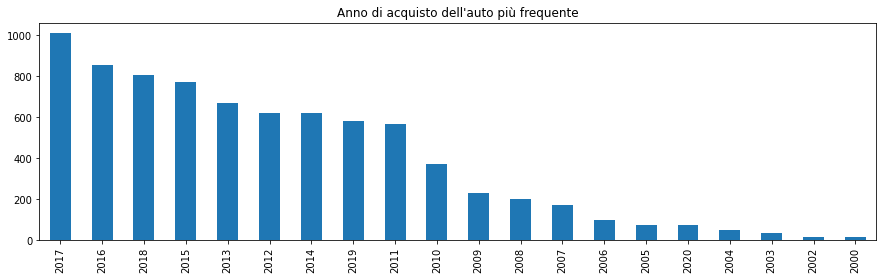

In [158]:
data['year'].value_counts()[:20].plot.bar(figsize=(15, 4));
plt.axes().set_title("Anno di acquisto dell'auto più frequente");

Notiamo che l'anno di primo acquisto, il 2017 è l'anno in cui sono state acquistate più auto.

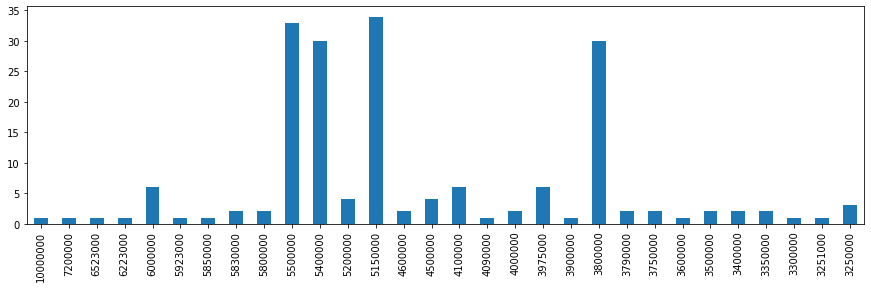

In [159]:
data["selling_price"].value_counts().sort_index(ascending=False)[:30].plot.bar(figsize=(15, 4));

Per il prezzo di vendita, ovvero la feature da predire, si può notare come i prezzi varino molto tra le auto vendute

### Numero di posti auto

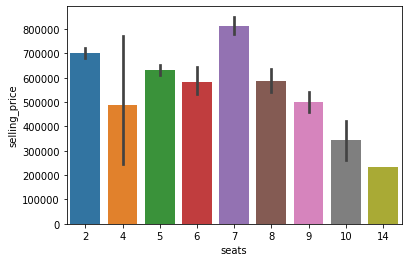

In [160]:
sns.barplot(x='seats',y='selling_price',data=data)

Notiamo che Le auto con 7 posti hanno un prezzo di vendita più elevato rispetto alle altre, sono poi seguite da quelle da 2 posti e da 5. Quelle vendute ad un prezzo più basso risultano con 14 posti.

Le barre nere indicano l'errore con un intervallo di confidenza del 95%, ossia danno un'idea generale di quanto sia precisa una misurazione o, al contrario, di quanto lontano dal valore riportato potrebbe essere il valore vero (privo di errori). In questo caso notiamo che vi è poca precisione per quanto riguarda le auto con 4 posti ciò significa che il loro valore è più variabile, mentre risulta più elevata per quelle a 14 e 2 posti.

### Numero di precedenti proprietari

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


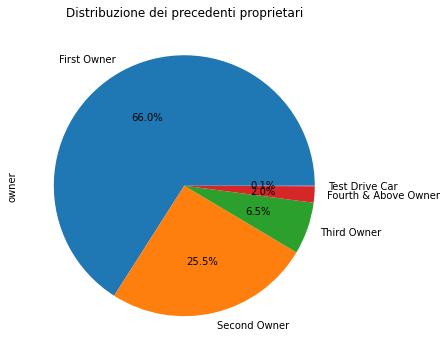

In [161]:
plt.figure(figsize=(10,6));
data['owner'].value_counts().plot.pie(autopct='%1.1f%%');
plt.axes().set_title('Distribuzione dei precedenti proprietari');

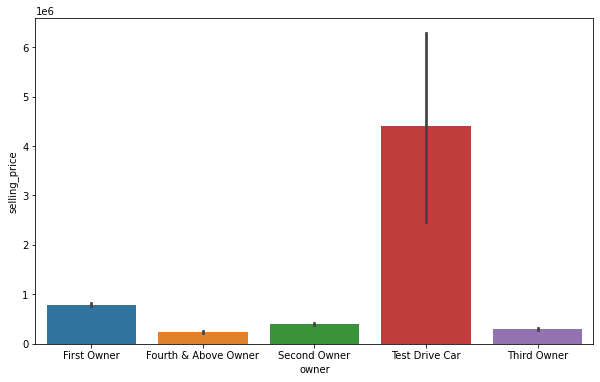

In [162]:
plt.figure(figsize=(10,6))
sns.barplot(x='owner',y='selling_price',data=data);

E' possibile notare come le auto del dataset abbiano avuto principalmente un solo proprietario prima di essere rivendute, ma che quelle vendute ad un prezzo maggiore risultano le test drive anche se più variabile rispetto alle altre.

### Tipo di venditore

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


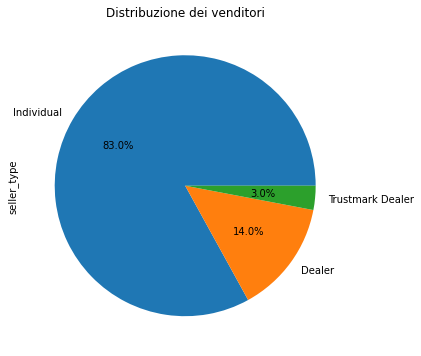

In [163]:
plt.figure(figsize=(10,6))
data['seller_type'].value_counts().plot.pie(autopct='%1.1f%%');
plt.axes().set_title('Distribuzione dei venditori');

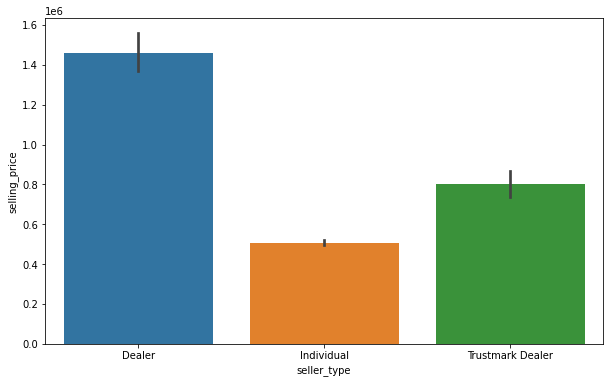

In [164]:
plt.figure(figsize=(10,6))
sns.barplot(x='seller_type',y='selling_price',data=data);

Vediamo una netta predominanza di venditori privati e solo una piccola percentuale di rivenditori di marchi di fiducia. Il prezzo di vendita delle auto risulta però maggiore nel caso dei rivenditori piuttosto che per i privati.

### Tipo di cambio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


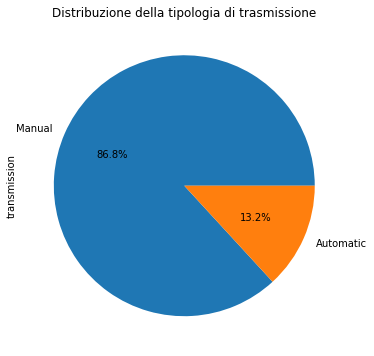

In [165]:
plt.figure(figsize=(10,6))
data['transmission'].value_counts().plot.pie(autopct='%1.1f%%');
plt.axes().set_title('Distribuzione della tipologia di trasmissione');

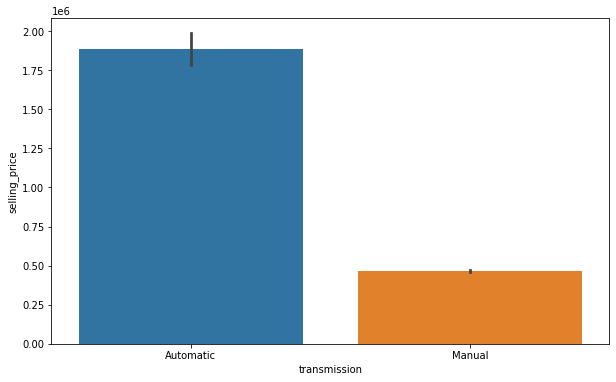

In [166]:
plt.figure(figsize=(10,6))
sns.barplot(x='transmission',y='selling_price',data=data);

Notiamo che la maggior parte delle auto vendute avevano un cambio manuale, ma che il loro prezzo di vendita è nettamente inferiore rispetto a quelle a cambio automatico.

### Tipo di carburante

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


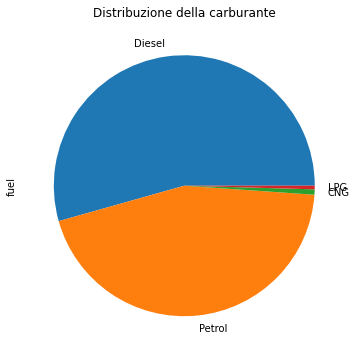

In [167]:
plt.figure(figsize=(10,6))
data['fuel'].value_counts().plot.pie();
plt.axes().set_title('Distribuzione della carburante');

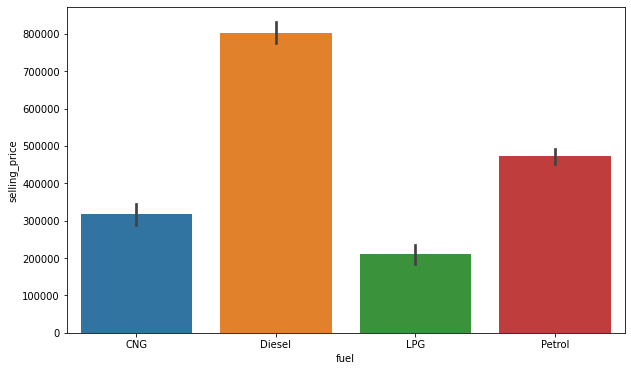

In [168]:
plt.figure(figsize=(10,6))
sns.barplot(x='fuel', y='selling_price', data = data);

Non vi è una siglificativa differenza tra auto a Diesel e Benzina le quali hanno un prezzo di vendita maggiore, mentre vi è una netta minoranza di CNG (Metano) e LPG (GPL) il cui prezzo risulta anche minore. 

### Chilometraggio - prezzo di vendita

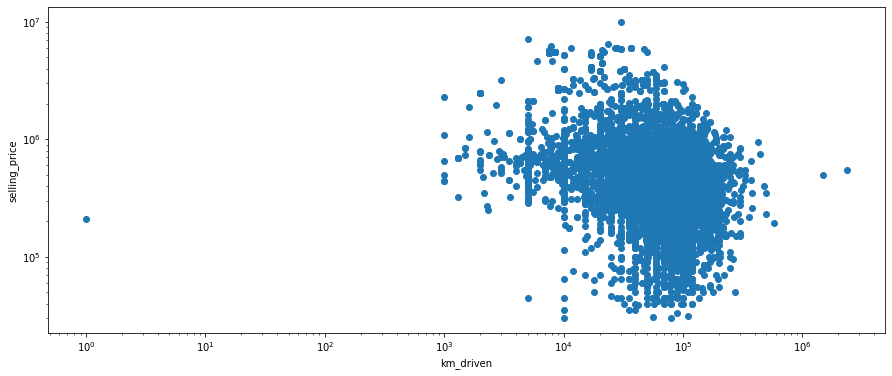

In [169]:
#essendo sia il prezzo che i chilometri sull'ordine delle migliaia, 
#utilizzo la scala logaritmica per visualizzare il grafico
plt.figure(figsize=(15,6))
plt.xscale('log')
plt.yscale('log')
plt.scatter(data['km_driven'],data['selling_price']);
plt.xlabel('km_driven');
plt.ylabel('selling_price');

Notiamo un'elevata concentrazione di prezzi sull'ordine di $10^5$ e $10^6$ per auto con un chilometraggio intorno a 100.000km

### Anni di circolazione - prezzo di vendita

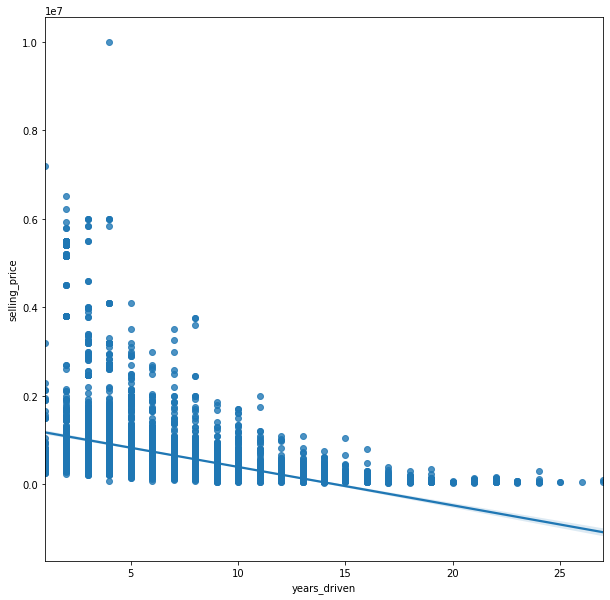

In [170]:
plt.figure(figsize=(10,10))
sns.regplot(x='years_driven',y='selling_price',data=data);


Mettendo a confronto gli anni di circolazione dell'auto e il prezzo di vendita è possibile notare come più gl'anni aumentino e più il prezzo diventi inferiore.

### Statistiche decrittive

In [171]:
data.describe()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,years_driven
count,7906.000000,7.906000e+03,7.906000e+03,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000
mean,2013.983936,6.498137e+05,6.918866e+04,19.419861,1458.708829,91.587374,168.294141,5.416393,7.016064
std,3.863695,8.135827e+05,5.679230e+04,4.036263,503.893057,35.747216,97.313384,0.959208,3.863695
min,1994.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,32.800000,4.800000,2.000000,1.000000
25%,2012.000000,2.700000e+05,3.500000e+04,16.780000,1197.000000,68.050000,101.000000,5.000000,4.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,154.900000,5.000000,6.000000
75%,2017.000000,6.900000e+05,9.542500e+04,22.320000,1582.000000,102.000000,202.000000,5.000000,9.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,789.000000,14.000000,27.000000


Passiamo ora a visualizzare la distribuzione dei dati

Prendendo in considerazione le statistiche notiamo che:

*  l'auto più vecchia è del 1994, il che fa si che gli anni di circolazione siano pari a 27 (max(years_driven)), mente quella più recente è del 2020, con solo un anno di circolazione.
*   il prezzo medio di vendita è pari 649813. Tale feature ha un massimo pari a 10.000.000 e un minimo di 29999. Il valore è molto variabile, lo si può notare dalla varianza. 
* per quanto riguarda il chilometraggio delle auto mediamente è pari a 69188 km, mentre il consumo medio al chilometro è di 19,4 l/km

Visualizziamo tali dati mediante un boxplot



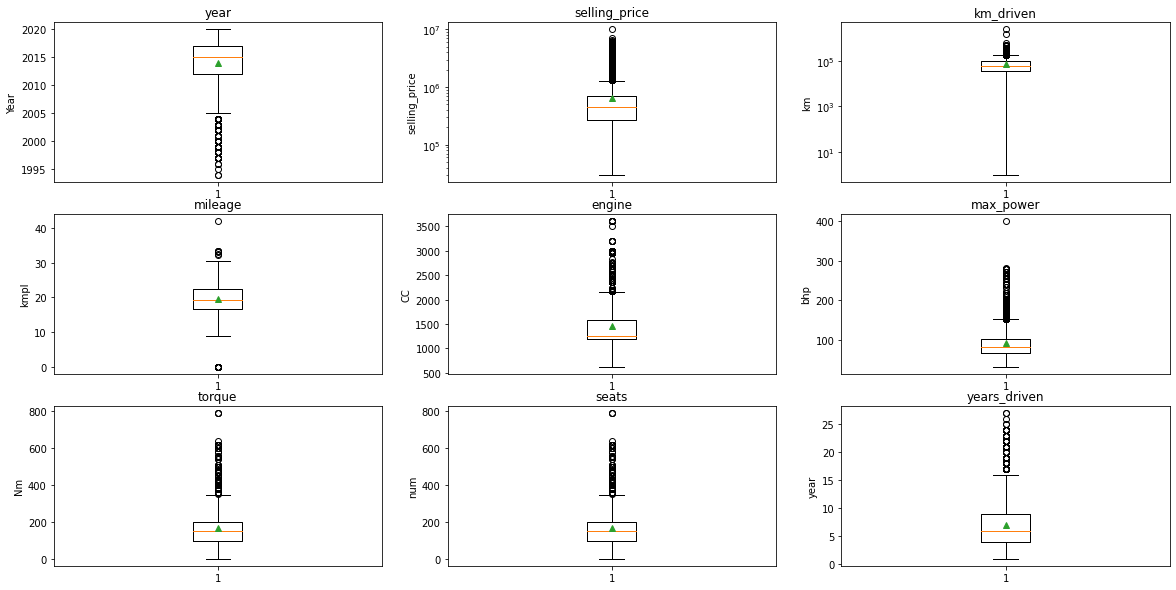

In [172]:
plt.figure(figsize=(20, 10))

plt.subplot(3, 3, 1)
plt.title('year')
plt.boxplot(data['year'],showmeans=True)
plt.ylabel('Year')

plt.subplot(3, 3, 2)
plt.title('selling_price')
plt.yscale('log')
plt.boxplot(data['selling_price'],showmeans=True)
plt.ylabel('selling_price')

plt.subplot(3, 3, 3)
plt.title('km_driven')
plt.yscale('log')
plt.boxplot(data['km_driven'],showmeans=True)
plt.ylabel('km')

plt.subplot(3, 3, 4)
plt.title('mileage')
plt.boxplot(data['mileage'],showmeans=True)
plt.ylabel('kmpl')

plt.subplot(3, 3, 5)
plt.title('engine')
plt.boxplot(data['engine'],showmeans=True)
plt.ylabel('CC')

plt.subplot(3, 3, 6)
plt.title('max_power')
plt.boxplot(data['max_power'],showmeans=True)
plt.ylabel('bhp')

plt.subplot(3, 3, 7)
plt.title('torque')
plt.boxplot(data['torque'],showmeans=True)
plt.ylabel('Nm')

plt.subplot(3, 3, 8)
plt.title('seats')
plt.boxplot(data['torque'],showmeans=True)
plt.ylabel('num')

plt.subplot(3, 3, 9)
plt.title('years_driven')
plt.boxplot(data['years_driven'],showmeans=True)
plt.ylabel('year')

plt.show()

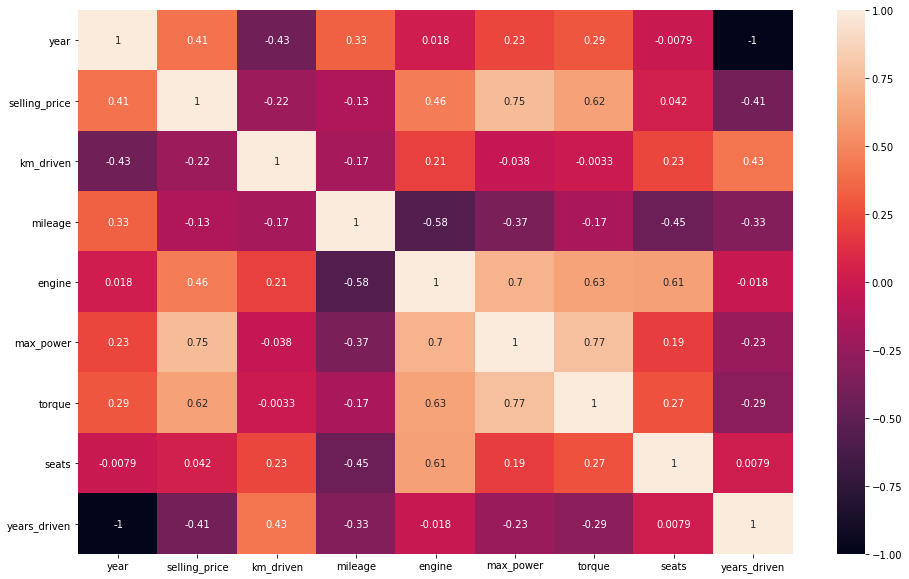

In [173]:
#plotting the heatmap
plt.figure(figsize=(16,10))
sns.heatmap(data.corr(),annot=True)
plt.show()

Producendo una matrice di correlazione delle features, possiamo osservare le seguenti correlazioni rilevanti:
* `selling_price` è correlato positivamente con `year`, `torque`, `max_power` e `engine`, al contrario sembra avere una correlazione negativa con `km_diven` e `mileage`.
* Come ci si poteva aspettare vi è un'elevata correlazione tra `max_power` e `engine`. La cilindrata, infatti, misura il volume d'aria teoricamente aspirato durante un ciclo fisico da una macchina volumetrica (il cilindro), più aria entra e più sarà elevata la potenza che il motore produce.
* Un'elevata correlazione è presente anche tra `max_power` e `torque`, ma anche questa deriva dal rapporto fisico tra le due feature. Infatti la potenza del motore è data da $Potenza = coppia * velocita' $
* Infine i chilometri percorsi `km_driven` dipendono, come ci si aspettava dall'anno in cui l'auto è stata acquistata `year` e quindi anche dagl'anni che l'auto è in circolazione `years_driven`.

# 2- Elaborazione delle features

In base alle considerazioni effettuate sulla base della correlazione, si decide di rimuovere la feature `seats` in quanto essere quella meno correlata al prezzo di vendita dell'auto. Essendo inoltre il nome delle auto ad alta variabilità, e l'anno di vendita indicabile mediante gl'anni di circolazione dell'auto, si decide di rimuoverli dal dataset.

In [174]:
data.drop(columns='seats', inplace=True)
data.drop(columns='name', inplace=True)
data.drop(columns='year', inplace=True)

In [175]:
data.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,years_driven
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,7
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,7
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,15
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,11
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,14


## Binarizzazione dei dati categorici
Procediamo ora a binarizzare i dati categorici, questo ci permetterà di poterli confrontare con gli altri dati e successivamente per la generazione dei modelli

La binarizzazione avverrà mediante il metodo **One Hot Encoding**

One Hot Encoding è un processo nell'elaborazione dei dati che viene applicato ai dati categoriali, per convertirli in una rappresentazione vettoriale binaria da utilizzare negli algoritmi di apprendimento automatico.

Si convertono ora le features categoriche splittando i loro valori nelle rispettive classi di appartenenza creando una colonna per ogni classe. Nelle celle sarà presente un 1 solo in corrispondenza della classe di appartenenza e 0 negli altri casi.

In [176]:
from sklearn.preprocessing import OneHotEncoder # per applicare la binarizzazione delle variabili categoriche
from sklearn.compose import ColumnTransformer #per applicare preprocessing differenziato

In [177]:
numerical = data.columns[~data.columns.isin(categorical + ['selling_price'])]
numerical

Index(['km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'years_driven'],
      dtype='object')

In [178]:
encoder = OneHotEncoder(sparse=False) 
X_cat = data[categorical]

categorical_df = pd.DataFrame(
    encoder.fit_transform(X_cat),
    columns=encoder.get_feature_names(X_cat.columns)
)
categorical_df.head(5)

,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Utilizziamo una heatmap per visualizzare la correlazione tra le variabili del dataset finale. Lo stesso risultato ottenuto con OneHotEncoded è ottenibile con pd.get_dummies()

In [179]:
final_data = pd.get_dummies(data) 
#poichè utilizzerò la regolarizzazione al momento non specifico drop_firt=True, successivamente se necessario rimuoverò tali feature 
final_data.head()

,selling_price,km_driven,mileage,engine,max_power,torque,years_driven,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,450000,145500,23.40,1248,74.00,190.0,7,0,1,0,0,0,1,0,0,1,1,0,0,0,0
1,370000,120000,21.14,1498,103.52,250.0,7,0,1,0,0,0,1,0,0,1,0,0,1,0,0
2,158000,140000,17.70,1497,78.00,12.7,15,0,0,0,1,0,1,0,0,1,0,0,0,0,1
3,225000,127000,23.00,1396,90.00,22.4,11,0,1,0,0,0,1,0,0,1,1,0,0,0,0
4,130000,120000,16.10,1298,88.20,11.5,14,0,0,0,1,0,1,0,0,1,1,0,0,0,0


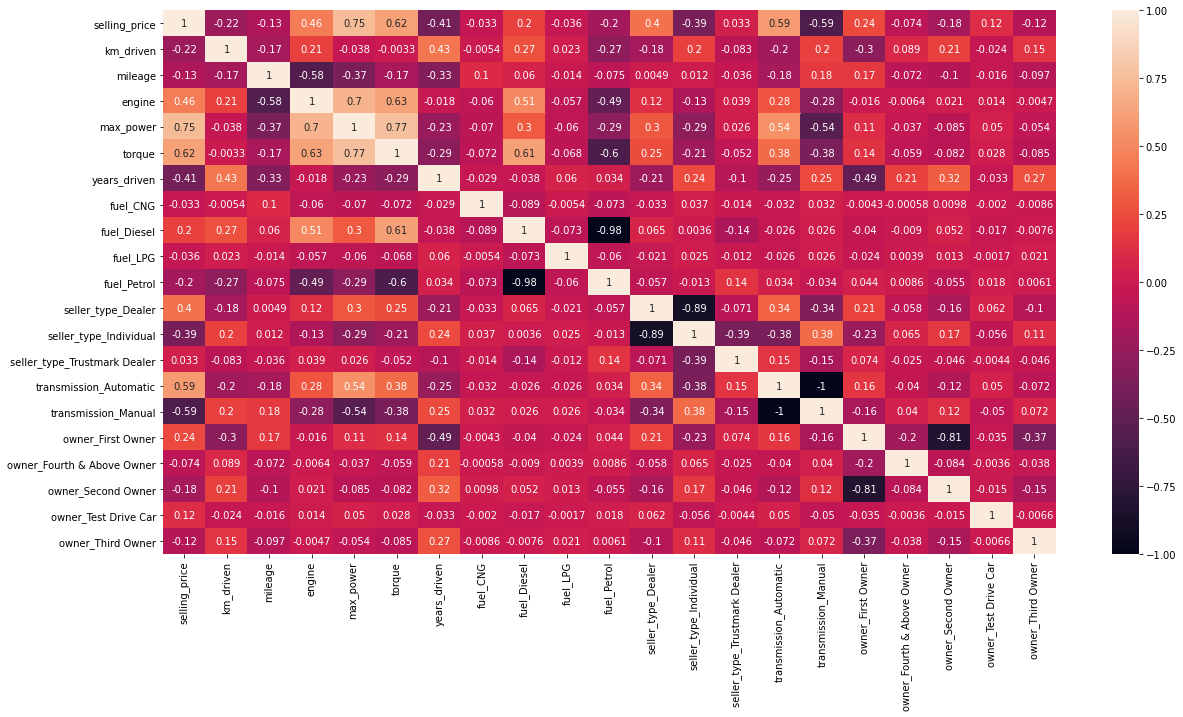

In [180]:
#plotting the heatmap
plt.figure(figsize=(20,10))
sns.heatmap(final_data.corr(),annot=True)
plt.show()

Analizzando la correlazione tra `selling_price` e  le variabili categoriche è possibile constatare che le auto che hanno avuto un solo proprietario hanno una correlazione positiva con il prezzo di vendita, così pure il cambio automatico, il diesel e come venditore un rivenditore, mentre il cambio manuale e la vendita da parte di un privato hanno una correlazione negativa.

Prendendo sempre in considerazione la variabile da predire `selling_price`  analizziamo la correlazione con le altre variabili.

Notiamo che le features con una correlazione positiva con la nostra variabile sono i cilindri dell'auto, la potenza, la coppia motore, il tipo di cambio automatico. Al contrario notiamo che quelle con una correlazione negativa sono i chilometri percorsi, il consumo al chilometro e gli anni di circolazione.

Utilizziamo ora la funzione pairplot di seaborn per comprendere la relazione tra le features e la variabile da predire.

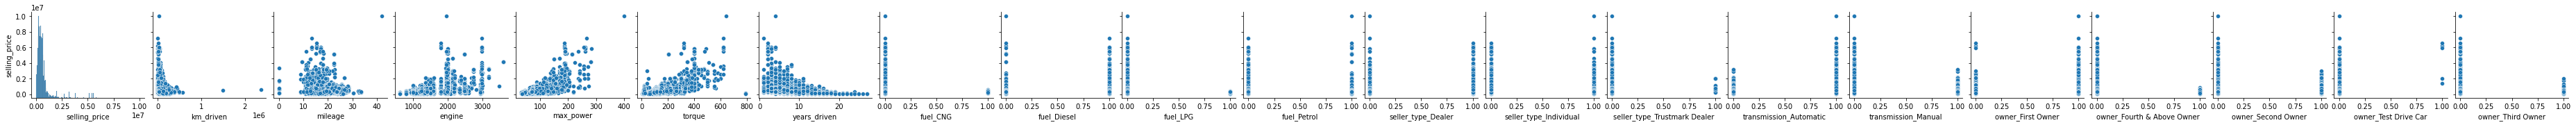

In [181]:
sns.pairplot(final_data, 
            y_vars=["selling_price"])

## Standardizzazione, Regolarizzarione e selezione delle feature

Poichè le istanze del dataset hanno ordini di grandezza diversi si procede anche alla standardizzazione delle feature mediante StandardScaler al fine di uniformare i valori.


Importiamo come prima cosa le librerie necessarie.

In [182]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Dividiamo mediante il metodo di hold out i dati in training e validation set, assegnando al validation set 1/3 e al training set 2/3 dei dati

In [183]:
y = data['selling_price'] 
X = data.drop(columns="selling_price")

In [184]:
y.head()

0    450000
1    370000
2    158000
3    225000
4    130000
Name: selling_price, dtype: int64

In [185]:
X.head()

,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,years_driven
0,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,7
1,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,7
2,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,15
3,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,11
4,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,14


In [186]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.3, random_state=42)

Ora che il dataset è stato diviso procediamo alla creazione e alla valutazione dei modelli al fine di avere una prima conoscenza sulle features rimaste più importanti per il modello.

In [187]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [188]:
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [189]:

#definiamo la metodologia di cross-validation da applicare 
kf = KFold(5, shuffle=True, random_state=42)

def pred_model(model):
    # Training model
    model.fit(X_train,y_train)
            
    # R2 score of train set
    y_pred_train = model.predict(X_train)
    R2_train_model = r2_score(y_train,y_pred_train)
    #R2_train.append(round(R2_train_model,2))
    
    # R2 score of test set
    y_pred_val = model.predict(X_val)
    R2_test_model = r2_score(y_val,y_pred_val)
    #R2_test.append(round(R2_test_model,2))
    
    # R2 mean of train set using Cross validation
    cross_val = cross_val_score(model, X_train , y_train ,cv=kf)
    cv_mean = cross_val.mean()
    #R2_train_cross_validate.append(round(cv_mean,2))
    
    # Printing results
    #print("Mean squared error :",round(mean_squared_error(y_val, y_pred_val),2))
    print("Relative error : ",round(relative_error(y_val, y_pred_val),2))
    print("Train R2-score :",round(R2_train_model,2))
    print("Test R2-score :",round(R2_test_model,2))
    print("Train CV scores :",cross_val)
    print("Train CV mean :",round(cv_mean,2))
    print(pd.Series(model.named_steps['reg'].coef_, final_data.drop(columns=['selling_price']).columns))


Utilizzeremo la regressione Lasso con vari valori di L1 per verificare se sono presenti delle feature meno rilevanti


In [190]:
from sklearn.model_selection import GridSearchCV

In [191]:
lasso_grid = Pipeline([
    ('preproc', ColumnTransformer([
                 ('categorical', OneHotEncoder(), categorical)],remainder=StandardScaler())),
    ("reg",  Lasso(random_state=42))
])

grid = {
    "reg__alpha":  np.arange(0, 1, 0.01)
}
gs = GridSearchCV(lasso_grid, grid, cv=kf, refit=True)
gs.fit(X_train, y_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converg

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
98,0.153131,0.043154,0.010403,0.000549,0.98,{'reg__alpha': 0.98},0.661687,0.666258,0.670089,0.689199,0.689197,0.675286,0.011666,1
99,0.180638,0.024105,0.013916,0.002319,0.99,{'reg__alpha': 0.99},0.661687,0.666257,0.670089,0.689199,0.689196,0.675286,0.011666,2
95,0.199806,0.035487,0.014397,0.000404,0.95,{'reg__alpha': 0.9500000000000001},0.661686,0.666258,0.670089,0.689199,0.689197,0.675286,0.011667,3
97,0.171330,0.048254,0.011783,0.001926,0.97,{'reg__alpha': 0.97},0.661687,0.666258,0.670089,0.689199,0.689197,0.675286,0.011667,4
96,0.191447,0.043597,0.013953,0.002197,0.96,{'reg__alpha': 0.96},0.661687,0.666258,0.670089,0.689199,0.689197,0.675286,0.011667,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.179953,0.007792,0.010356,0.000129,0.04,{'reg__alpha': 0.04},0.661666,0.666266,0.670089,0.689200,0.689207,0.675285,0.011673,96
3,0.201501,0.020484,0.012755,0.002248,0.03,{'reg__alpha': 0.03},0.661666,0.666266,0.670089,0.689200,0.689207,0.675285,0.011673,97
2,0.174703,0.005730,0.010770,0.001476,0.02,{'reg__alpha': 0.02},0.661666,0.666266,0.670089,0.689200,0.689207,0.675285,0.011673,98
1,0.216381,0.018981,0.014357,0.000705,0.01,{'reg__alpha': 0.01},0.661666,0.666266,0.670089,0.689200,0.689207,0.675285,0.011673,99


In [192]:
print(gs.best_params_)

{'reg__alpha': 0.98}


Addestriamo un modello Lasso con l'iperparametro trovato e visualizziamo le feature che vengono poste a 0

In [193]:
lasso_model_grid = Pipeline([
                   ('preproc', ColumnTransformer([
                                   ('categorical', OneHotEncoder(), categorical)],remainder=StandardScaler())),
                   ('reg', Lasso(alpha=0.98, random_state=42))
])

pred_model(lasso_model_grid)

Relative error :  0.74
Train R2-score : 0.68
Test R2-score : 0.69
Train CV scores : [0.66168706 0.66625751 0.67008922 0.68919923 0.68919652]
Train CV mean : 0.68
km_driven                       2.444692e+05
mileage                         1.614146e+04
engine                         -7.099147e+04
max_power                       4.527512e+05
torque                         -0.000000e+00
years_driven                    5.925158e+04
fuel_CNG                        2.096817e+04
fuel_Diesel                     2.639993e+05
fuel_LPG                       -4.903533e+03
fuel_Petrol                     3.459499e+04
seller_type_Dealer              7.382830e+04
seller_type_Individual         -1.618094e+04
seller_type_Trustmark Dealer    2.323456e+06
transmission_Automatic         -0.000000e+00
transmission_Manual            -7.362942e+04
owner_First Owner               6.159392e+04
owner_Fourth & Above Owner      3.258565e+04
owner_Second Owner              4.487870e+05
owner_Test Drive Car        

Dai segni dei coefficienti possiamo vedere quali fenomeni influiscono positivamente e negativamente sul prezzo di vendita. Ad esempio notiamo che il prezzo aumenta per le auto vendute da un rivenditore specializzato e con una potenza elevata, mentre diminuisce se il numero di proprietari precedenti è 3.

Poichè i dati categorici vengono binarizzati dai modelli, si procede a rimuovere solo le features `mileage` e `torque`

In [194]:
final_data = data.drop(columns=['torque'])

In [195]:
final_data.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,years_driven
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,7
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,7
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,15
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,11
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,14


In [196]:
#rimuovo mileage anche dalla lista delle feature numeriche
numerical = data.columns[~data.columns.isin(categorical + ['selling_price', 'torque'])] 
numerical

Index(['km_driven', 'mileage', 'engine', 'max_power', 'years_driven'], dtype='object')

In [197]:
final_data.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,years_driven
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,7
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,7
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,15
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,11
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,14


Estraiamo alcuni dati dal dataset in modo da ottenere un dataFrame utilizzabile come test una volta trovato il modello più adeguato.

In [198]:
final_data.shape #shape originale di final_data

(7906, 10)

In [199]:
test_data = final_data[::20]
test_data.shape

(396, 10)

In [200]:
final_data = final_data[~final_data.index.isin(test_data.index)]

In [201]:
final_data.shape #shape finale di final_data

(7510, 10)

Procediamo ora ridividendo il dataset

In [202]:
y = final_data['selling_price'] 
X = final_data.drop(columns="selling_price")

In [203]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [204]:
X.head()

,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,years_driven
1,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,7
2,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,15
3,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,11
4,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,14
5,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,4


# 3- Modellazione

Il nostro obiettivo finale è quello di ottenere un modello di regressione sui dati in modo da poter ottenere direttamente il prezzo di vendita delle auto.

Andiamo quindi a testare alcune tecniche di regressione per valutare quella che meglio si presta al nostro tipo di problema.

Oltre a quello precedentemente visto durante la fase di selezione delle features saranno testati altri modelli di regressione sul dataset aggiornato. Faremo uso di **Grid Search** e **K-fold cross validation** saranno quindi generati 5 modelli differenti in grado di stimare gli iperparametri e permettere il calcolo dell'accuratezza dei modelli studiati.

Definiamo alcune funzioni che ci permetteranno di valutare i modelli. Inizializziamo anche un dizionario dove memorizzeremo i valori del MSE, errore relativo e coefficiente $R^2$ in modo poi da poter confrontare i modelli.

In [205]:
models = {}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def print_k_cross_validation_scores(model, X, y, kf):
    scores = cross_val_score(model, X, y, cv=kf)
    print("            Scores: {}\n              Mean: {}\nStandard deviation: {}".format(scores, scores.mean(), scores.std()))

def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def grid_search_with_cross_validation(model, grid, kf):
    grid_search = GridSearchCV(model, grid, cv=kf, refit=True)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

    grid_search.fit(X_train, y_train)
    
    #score = grid_search.score(X_val, y_val)

    print("Best cross validation score: {}\n".format(grid_search.best_score_))
    #print("             Test set score: {}\n".format(score))
    print("                Best params: {}\n".format(grid_search.best_params_))
    print("             Best estimator: {}\n".format(grid_search.best_estimator_))

    preds = grid_search.best_estimator_.predict(X_val)
    MSE = mean_squared_error(y_val, preds)
    RE = relative_error(y_val, preds)
    R2 = r2_score(y_val, preds)
    print("   Mean squared error: {:.5}".format(MSE))
    print("       Relative error: {:.5%}".format(RE))
    print("R-squared coefficient: {:.5}\n".format(R2))



    return grid_search.best_estimator_, MSE, RE, R2 #ho tolto score
    #print(pd.DataFrame(grid_search.cv_results_))

## Linear Regression

In [206]:
%%time
linear_model = Pipeline([
                ("preproc", ColumnTransformer([
                    ("numeric", StandardScaler(), numerical),
                    ("categorical", OneHotEncoder(), categorical)
                ])),
                   ('reg', LinearRegression())
])
grid={}

linear_model, MSE, RE, R2 = grid_search_with_cross_validation(linear_model, grid, kfold)
print_k_cross_validation_scores(linear_model, X, y, kfold)
models["Linear Regression"] = {"Model" : linear_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.6836948442597272

                Best params: {}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'years_driven'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                                                drop=

Il modello lineare ha un indice $R^2$ abbastanza basso, il che significa che non descrive benissimo i dati. Ciò potrebbe essere dovuto ad un elevato valore dei coefficienti.

## Ridge Regression
Procediamo con una regressione di tipo Ridge, la quale applica una regolarizzazione L2, indicata dal parametro *alpha*, alle features

In [207]:
%%time
ridge_model = Pipeline([
                   ("preproc", ColumnTransformer([
                        ("numeric", StandardScaler(), numerical),
                        ("categorical", OneHotEncoder(), categorical)
                    ])),
                   ('reg', Ridge(random_state=42))
])
grid={
    "reg__alpha": [0.1, 1, 10]
}

ridge_model, MSE, RE, R2 = grid_search_with_cross_validation(ridge_model, grid, kfold)
print_k_cross_validation_scores(ridge_model, X, y, kfold)
models["Ridge Regression"] = {"Model" : ridge_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.6839063774225493

                Best params: {'reg__alpha': 1}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'years_driven'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                                      

Anche applicando una regolarizzazione ai coefficienti il valore di $R^2$ non è migliorato, al contrario è aumentato l'errore relativo commesso sui dati.

## ElasticNet
Un altro possibile modello è ElasticNet, il quale oltre ad applicare la regolarizzazione mediante L2, permette anche di applicare la selezione delle feature derivante da Lasso, questo impostando il parametro *l1_ratio*

In [208]:
%%time
elasticNet_model = Pipeline([
                   ("preproc", ColumnTransformer([
                        ("numeric", StandardScaler(), numerical),
                        ("categorical", OneHotEncoder(), categorical)
                    ])),
                   ('reg', ElasticNet(random_state=42))
])
grid={
    "reg__alpha": [0.1, 1, 10],
    "reg__l1_ratio": [0.1, 0.25, 0.5]
}

elasticNet_model, MSE, RE, R2 = grid_search_with_cross_validation(elasticNet_model, grid, kfold)
print_k_cross_validation_scores(elasticNet_model, X, y, kfold)
models["ElasticNet Regression"] = {"Model" : elasticNet_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.6762994673565904

                Best params: {'reg__alpha': 0.1, 'reg__l1_ratio': 0.5}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'years_driven'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                              

Anche mediante ElasticNet il modello non migliora. Si procede quindi all'utilizzo di modelli non lineari.

## KernelRidge Regression

L'utilizzo di feature non lineari potrebbe migliorare il modello di regressione. Mediante la regressione polinomiale si eseguono prodotti tra dati con dimensioni aggiunte e rappresentate esplicitamente, ciò implica un aumento delle feature con il conseguente aumento dei tempi di addestramento.

Per far fronte all'aumento delle feature si utilizzano le *funzioni kernel*, tali funzioni permettono di calcolare gli stessi prodotti senza calcolare esplicitamente le dimensioni aggiunte. Esistono diversi tipi di kernel, per questo progetto utilizzeremo:
* kernel polinomiale: $K(\mathbf{a},\mathbf{b}) = \left(\mathbf{a}\cdot\mathbf{b}+c\right)^d $ , dove *d* è il grado del polinomio
* kernel RBF (*radial basis function):  $K(\mathbf{a},\mathbf{b}) = exp(-{\frac{||\mathbf{a}-\mathbf{b}||_2 ^ 2}{2\sigma^2} })$

In [209]:
from sklearn.kernel_ridge import KernelRidge

In [210]:
#per disabilitare i warning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

kernelRidge come si può intuire dal nome implementa la regressione ridge con l'applicazione di una funzione kernel. Anche per la sua applicazione faremo uso della gridSearch per individuare gli iperparametri migliori. 

In [211]:
%%time

kernel_ridge_poly_model = Pipeline([
    ("preproc", ColumnTransformer([
                    ("numeric", StandardScaler(), numerical),
                    ("categorical", OneHotEncoder(), categorical)
                ])),
    ("reg", KernelRidge(kernel='poly'))
])


kernel_ridge_grid = [
                     {'reg__alpha' :  [0.01, 0.1, 1, 10],
                      'reg__degree' : range(2, 5)
                      }
                  ]

kernel_ridge_poly_model, MSE, RE, R2 = grid_search_with_cross_validation(kernel_ridge_poly_model, kernel_ridge_grid, kfold)
print_k_cross_validation_scores(kernel_ridge_poly_model, X, y, kfold)
models["KernelRidge poly Regression"] = {"Model" : kernel_ridge_poly_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.9292342210341141

                Best params: {'reg__alpha': 1, 'reg__degree': 3}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'years_driven'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                    

Come si può notare i tempi di esecuzione sono aumentati considerevolmente rispetto a quelli dei modelli lineari.

Il coefficiente risulta però peggiorato rispetto ai modelli precedenti

Utilizziamo una RBF ossia una funzione non lineare più complessa della polinomiale per vedere se il valore $R^2$ aumenta.
 

In [212]:
%%time

kernel_ridge_rbf_model = Pipeline([
    ("preproc", ColumnTransformer([
                    ("numeric", StandardScaler(), numerical),
                    ("categorical", OneHotEncoder(), categorical)
                ])),
    ("reg", KernelRidge(kernel='rbf'))
])


kernel_ridge_grid = [
                     {'reg__alpha' :  [0.01, 0.1, 1, 10],
                      'reg__gamma' : [0.01, 0.1, 1, 10]
                      }
                  ]

kernel_ridge_rbf_model, MSE, RE, R2 = grid_search_with_cross_validation(kernel_ridge_rbf_model, kernel_ridge_grid, kfold)
print_k_cross_validation_scores(kernel_ridge_rbf_model, X, y, kfold)
models["KernelRidge rbf Regression"] = {"Model" : kernel_ridge_rbf_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.9267993118617515

                Best params: {'reg__alpha': 0.01, 'reg__gamma': 0.01}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'years_driven'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                               

Notiamo che l'utilizzo di una GausianRadialBasis descrive meglio i dati, ottenendo così un valore $R^2$ pari al 94%

## Albero decisionale

L'albero decisionale costruisce modelli di regressione o classificazione sotto forma di una struttura ad albero. Suddivide un insieme di dati in sottoinsiemi sempre più piccoli mentre allo stesso tempo viene sviluppato in modo incrementale un albero decisionale associato. Il risultato finale è un albero con nodi decisionali e nodi foglia. 

In [213]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.tree import plot_tree

In [214]:
%%time
decisionTree_model = Pipeline([
    ("preproc", ColumnTransformer([
                    ("numeric", StandardScaler(), numerical),
                    ("categorical", OneHotEncoder(), categorical)
                ])),
    ("reg", DecisionTreeRegressor(random_state=42))
])

decisionTree_grid = {
    'reg__max_depth': [3, 5, 10],
    "reg__min_samples_split": [2,0.02, 0.05, 0.1]

}

decisionTree_model, MSE, RE, R2 = grid_search_with_cross_validation(decisionTree_model, decisionTree_grid, kfold)
print_k_cross_validation_scores(decisionTree_model, X, y, kfold)
models["decisionTreeRegressor"] = {"Model" : decisionTree_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.9301709400473339

                Best params: {'reg__max_depth': 10, 'reg__min_samples_split': 2}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'years_driven'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                    

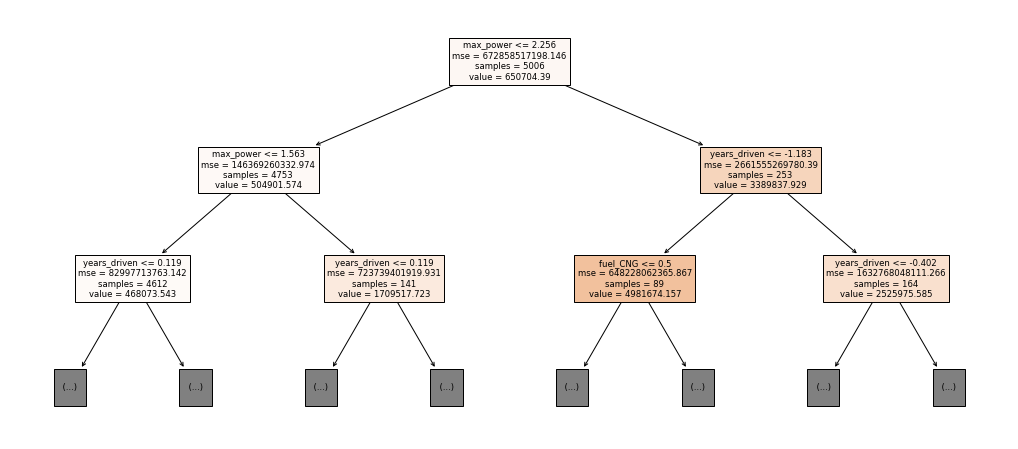

In [215]:
plt.figure(figsize=(18,8))
plot_tree(decisionTree_model.named_steps['reg'], 
          feature_names=list(pd.get_dummies(final_data.drop(columns=['selling_price'])).columns), 
          max_depth=2, filled=True);

In [216]:
decisionTree_model.named_steps['reg'].get_n_leaves()

363

In [217]:
#per una visione completa dell'albero decisionale
#from sklearn.tree import export_text, plot_tree
#print(export_text(decisionTree_model.named_steps['reg'], 
#                  feature_names=list(pd.get_dummies(final_data.drop(columns=['selling_price'])).columns)))

Mediante l'albero decisionale abbiamo ottenuto un ulteriore incremento di $R^2$. Procediamo ora con un modello che sfrutta gl'alberi decisionali per vedere se il modello migliora.

## Random forest

Un random forest è un tipo di modello ensemble, che si avvale del bagging come metodo di ensemble e l’albero decisionale come modello individuale.

Il risultato finale restituito dal Random Forest è la media del risultato numerico restituito dai diversi alberi.

Durante l’allenamento, ogni albero in una foresta casuale impara da un campione casuale di punti dati. I campioni vengono disegnati con la sostituzione, nota come bootstrap, il che significa che alcuni campioni verranno utilizzati più volte in un singolo albero.

L’idea è che addestrando ciascun albero su campioni diversi, sebbene ogni albero possa presentare una varianza elevata rispetto a una particolare serie di dati di addestramento, nel complesso l’intera foresta avrà una varianza inferiore ma non a costo di aumentare la distorsione.

Al momento del test, le previsioni vengono effettuate calcolando la media delle previsioni di ciascun albero decisionale (tecnica bagging vista precedentemente). [Come funziona un algoritmo Random Forest?](https://www.lorenzogovoni.com/random-forest/)

In [218]:
from sklearn.ensemble import RandomForestRegressor

In [219]:
# create regressor object
%%time
RandomForestRegressor_model = Pipeline([
    ("preproc", ColumnTransformer([
                    ("numeric", StandardScaler(), numerical),
                    ("categorical", OneHotEncoder(), categorical)
                ])),
    ("reg", RandomForestRegressor(random_state=42))
])
decisionTree_grid = {
    'reg__max_depth': [3, 5, 10],
    "reg__min_samples_split": [0.02, 0.05, 0.1]
}

RandomForestRegressor_model, MSE, RE, R2 = grid_search_with_cross_validation(RandomForestRegressor_model, decisionTree_grid, kfold)
print_k_cross_validation_scores(RandomForestRegressor_model, X, y, kfold)
models["RandomForestRegressor"] = {"Model" : RandomForestRegressor_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.8933365318947679

                Best params: {'reg__max_depth': 10, 'reg__min_samples_split': 0.02}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'years_driven'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                 

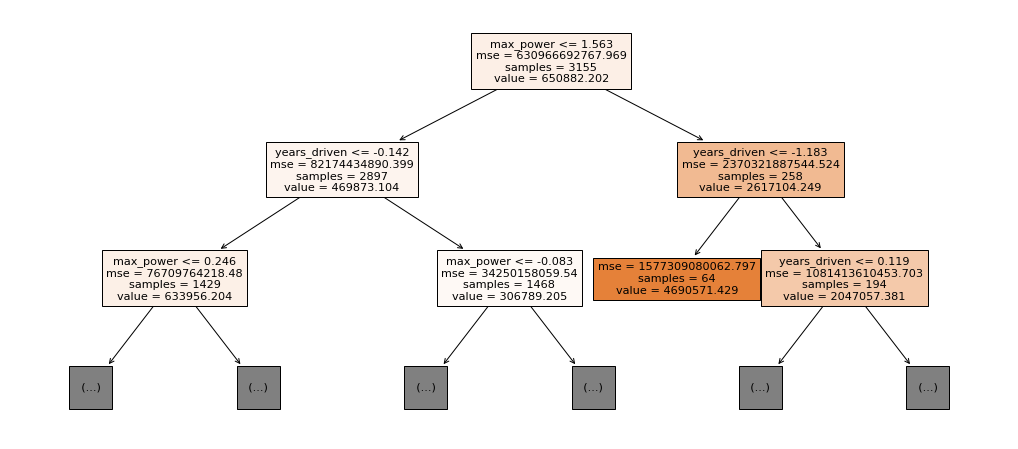

In [220]:
#estimator_ è la raccolta di sottostimatori (decisionTree) fittizi. Quello in posizione 0 è quello che da l'MSE minore.
plt.figure(figsize=(18,8))
plot_tree(RandomForestRegressor_model.named_steps['reg'].estimators_[0], 
          feature_names=list(pd.get_dummies(final_data.drop(columns=['selling_price'])).columns), 
          max_depth=2, filled=True);

In [221]:
RandomForestRegressor_model.named_steps['reg'].estimators_[0].get_n_leaves()

55

Sebbene il modello sia più semplice rispetto a quello ottenuto mediante il semplice utilizzo del DecisionTree, lo si vede dal numero di foglie ottenuto, RandomForest risulta peggiore rispetto al precedente modello.

## Riepilogo accuratezze

In [222]:
pd.DataFrame(models)[1:].T

,MSE,relative error,R^2
Linear Regression,2.12288e+11,0.779244,0.660993
Ridge Regression,2.12336e+11,0.780143,0.660916
ElasticNet Regression,2.13648e+11,0.755472,0.658821
KernelRidge poly Regression,5.48685e+11,0.282698,0.123793
KernelRidge rbf Regression,3.67734e+10,0.237826,0.941276
decisionTreeRegressor,3.20439e+10,0.192258,0.948828
RandomForestRegressor,5.4384e+10,0.217203,0.913153


In [223]:
#for name, model in models.items():
#  print(name)
#  print(model['Model'])
#  print('=============================')

# 4- Valutazione dei modelli

Dalle accuratezze trovate è possibile stabilire che il modello KernelRidge polinomiale non descrive bene i dati, si ha un miglioramento con la regressione Ridge e quella lineare anche se ancora non soddisfacente.

Sulla base delle accuratezze individuate scegliamo quindi i modelli che minimizzano gli errori (MSE e l'errore relativo) e che massimizzano l'indice $R^2$. Scegliamo quindi:
* **kernelRidge gaussian radial basis** 
* **DecisionTreeRegressor** 
* **RandomForestReressor** 



In [224]:
def print_eval(X, y, model):
    print("   Mean squared error: {:.5}".format(mean_squared_error(y,model.predict(X))))
    print("       Relative error: {:.5%}".format(relative_error(y,model.predict(X))))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))


In [225]:
models_name = ['KernelRidge rbf Regression','decisionTreeRegressor', 'RandomForestRegressor']
predictions = []
for num,name in enumerate(models_name,1):
  model = models[name]['Model']
  print(f"{name} model Train")
  print_eval(X_train, y_train, model)
  print("--------------------------------")
  print(f"{name} model Val")
  print_eval(X_val, y_val, model)
  predictions.append({name:model.predict(X_val)})
  
  print("\n================================\n")



KernelRidge rbf Regression model Train
   Mean squared error: 4.0351e+10
       Relative error: 23.63183%
R-squared coefficient: 0.94003
--------------------------------
KernelRidge rbf Regression model Val
   Mean squared error: 3.6773e+10
       Relative error: 23.78257%
R-squared coefficient: 0.94128


decisionTreeRegressor model Train
   Mean squared error: 8.2357e+09
       Relative error: 15.56118%
R-squared coefficient: 0.98776
--------------------------------
decisionTreeRegressor model Val
   Mean squared error: 3.2044e+10
       Relative error: 19.22585%
R-squared coefficient: 0.94883


RandomForestRegressor model Train
   Mean squared error: 6.4116e+10
       Relative error: 21.32589%
R-squared coefficient: 0.90471
--------------------------------
RandomForestRegressor model Val
   Mean squared error: 5.4384e+10
       Relative error: 21.72031%
R-squared coefficient: 0.91315




Dai valori ottenuti possiamo vedere come i modelli scelti non soffrono di overfitting, infatti sono presenti dei valori simili sia per quanto riguarda i dati di training che quelli di validation. 

Visionando i valori di $R^2$ e i grafici possiamo dire che il modello di tipo decisionTree è quello con $R^2$ maggiore quindi è quello che descrive meglio i dati, ciò lo si può anche vedere dall'errore relativo e dal MSE che sono i minori tra i tre modelli utilizzati.



Visualizziamo su dei grafici l'analisi del residuo ossia la differenza tra i valori reali e quelli predetti, per avere una ulteriore conferma 
della validità dei modelli

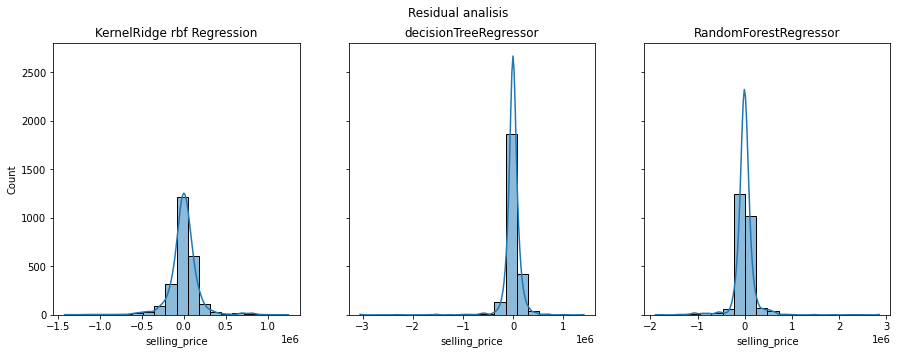

In [226]:
fig, axes = plt.subplots(1,3, figsize=(15, 5), sharey=True)
fig.suptitle('Residual analisis')
for i in range(3):
  sns.histplot((y_val- predictions[i][models_name[i]]),bins=20, ax=axes[i],kde=True)
  axes[i].set_title(models_name[i])

Come si intuiva dai valori dell' MSE e dell'errore relativo il modello con i residui più bassi ossia vicini allo zero risulta essere quello derivante dall'applicazione del DecisionTree. 

## Intervallo di confidenza

Verifichiamo con confidenza al 95% se l'errore relativo dei modelli è statisticamente significativo uno dall'altro.

In [227]:
from scipy import stats

In [228]:
def difference_between_two_models(error1, error2, confidence):
    z_half_alfa = stats.norm.ppf(confidence)
    variance = (((1 - error1) * error1) / len(y_val)) + (((1 - error2) * error2) / len(y_val))
    d_minus = abs(error1 - error2) - z_half_alfa * (pow(variance, 0.5))
    d_plus = abs(error1 - error2) + z_half_alfa * (pow(variance, 0.5))
    print("Valore minimo: {}\nValore massimo: {}\n".format(d_minus, d_plus))

rbf_error = 1 - models[models_name[0]]["relative error"]
tree_error = 1 - models[models_name[1]]["relative error"]
forest_error = 1 - models[models_name[2]]["relative error"]


print("rbf vs tree, intervallo di confidenza:")
difference_between_two_models(rbf_error, tree_error, 0.95)

print("rbf vs forest, intervallo di confidenza:")
difference_between_two_models(rbf_error, forest_error, 0.95)

print("Tree vs Forest, intervallo di confidenza:")
difference_between_two_models(tree_error, forest_error, 0.95)


rbf vs tree, intervallo di confidenza:
Valore minimo: 0.026497647786408004
Valore massimo: 0.06463681663935011

rbf vs forest, intervallo di confidenza:
Valore minimo: 0.0011402195108445
Valore massimo: 0.040105097810835294

Tree vs Forest, intervallo di confidenza:
Valore minimo: 0.006196088184169283
Valore massimo: 0.043693058919909045



Poichè tutti gli intervalli NON contengono lo zero per una confidenza del $95\% $, la loro differenza si ritiene statisticamente corretta.

#5- Analisi del modello migliore

Andiamo ora a vedere l'importanza, in temini di percentuale, che il modello DecisionTree, che è risultato il migliore, assegna ad ogni features e la relativa correlazione che hanno con la variabile da predire.

In [229]:
# get importance
importance = models[models_name[1]]['Model'].named_steps['reg'].feature_importances_
# summarize feature importance
features = pd.get_dummies(final_data.drop(columns=['selling_price'])).columns

d = pd.DataFrame(importance*100, index=features, columns=['importance'])
d['correlation'] = pd.get_dummies(final_data).corr()['selling_price'][1:]
d


,importance,correlation
km_driven,1.435414,-0.219313
mileage,1.661063,-0.128241
engine,0.786137,0.454012
max_power,73.853115,0.748613
years_driven,20.229491,-0.411791
fuel_CNG,1.151018,-0.032941
fuel_Diesel,0.014209,0.205323
fuel_LPG,0.000000,-0.036646
fuel_Petrol,0.096154,-0.195498
seller_type_Dealer,0.004505,0.397830


Si può notare che la feature a cui si assegna maggiore importanza è la potenza del motore (`max_power`) la quale ha un indice di correlazione positivo, seguita poi dagl'anni di circolazione dell'auto(`years_driven`) che sono invece inversamente proporzionali al costo dell'auto, e il consumo (`mileage`) anch'essi con una correlazione negativa, mentre ciò che è risultato meno importante al fine di costruire il modello predittivo risulta il cambio automatico, il tipo di carburante LPG. 

L'importanza assegnata è in linea con quello che spesso avviene nella realtà dove le features più significative sono solitamente la potenza e il consumo di carburante, i chilometri percorsi dall'auto e gl'anni di circolazione.


In [230]:
#pd.get_dummies(final_data).corr()['selling_price'][1:]

# Test di verifica

Valutiamo ora i modelli ottenuti sui dati di Test che avevamo precedentemente isolato.

In [231]:
test_data.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,years_driven
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,7
21,950000,50000,Diesel,Individual,Manual,First Owner,25.50,1498,98.60,4
42,925000,28900,Petrol,Dealer,Manual,First Owner,17.80,1497,117.30,3
62,190000,110000,Petrol,Individual,Manual,Third Owner,20.36,1197,78.90,10
83,484999,10000,Petrol,Dealer,Manual,First Owner,23.10,998,67.04,4


In [232]:
y_test = test_data['selling_price']
X_test = test_data.drop(columns="selling_price")

for name in models_name:
  print(f"{name} model Test")
  print_eval(X_test, y_test, models[name]['Model'])
  
  print("\n================================\n")

KernelRidge rbf Regression model Test
   Mean squared error: 4.4951e+10
       Relative error: 25.37470%
R-squared coefficient: 0.93988


decisionTreeRegressor model Test
   Mean squared error: 1.7209e+10
       Relative error: 19.47260%
R-squared coefficient: 0.97698


RandomForestRegressor model Test
   Mean squared error: 7.0937e+10
       Relative error: 24.67025%
R-squared coefficient: 0.90512




Come si può vedere i modelli scelti descrivono molto bene anche i dati nuovi. In particolare il DecisionTree è il modello che permette di avere una buona previsione del prezzo di vendita avendo un $R^2$ pari al $97,70%$. Tale caratteristica era visibile anche dal confronto tra Training set e Validation set.

Ovviamente nessun modello può descrivere perfettamente i dati in quanto il prezzo di vendita può essere sempre soggetto a delle trattative tra venditore e acquirente, ma nel complesso ci si può ritenere soddisfatti dei risultati ottenuti con il modello DecisionTree.